In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

from sklearn.cluster import KMeans, DBSCAN

In [2]:
geo = pd.read_excel('geo.xlsx')
geo_comment = pd.read_excel('geo_comment.xlsx')

In [3]:
geo.shape

(108806, 3)

In [4]:
geo.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [5]:
geo_comment.shape

(70382, 5)

In [6]:
geo_comment.head()

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo)
geo_scaled=pd.DataFrame(geo_scaled, columns=geo.columns)

In [8]:
geo_scaled.head()

,x,y,comment_class
0,0.367919,0.159553,-0.378889
1,0.367919,0.159553,-0.378889
2,0.293178,-0.348131,-0.378889
3,-0.073819,-0.539880,-0.378889
4,-0.009022,-0.496273,-0.378889


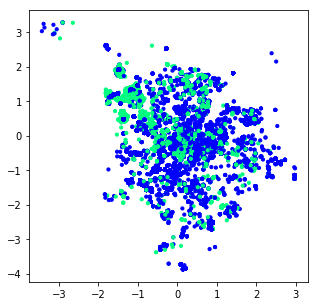

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(geo_scaled['x'], geo_scaled['y'], c=geo_scaled['comment_class'], cmap='winter', s=10)

In [10]:
method = KMeans(n_clusters=10)
clusters = method.fit_predict(geo_scaled[['x','y']],)

df = pd.DataFrame({'x':geo_scaled['x'],'y':geo_scaled['y'], 'cluster':clusters})

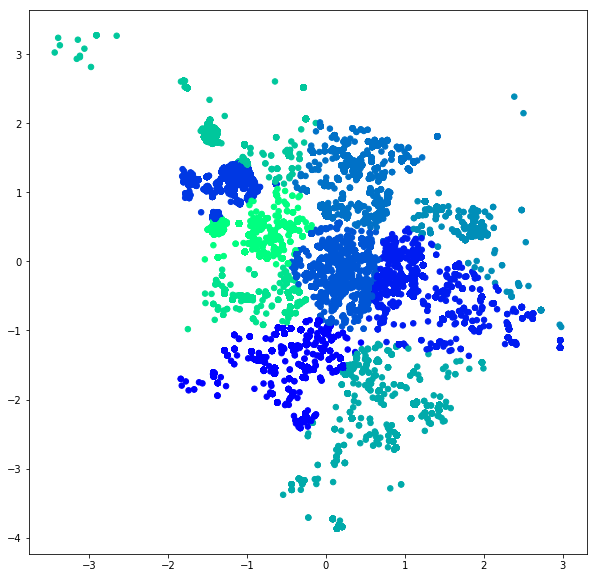

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(df.x, df.y, c=df.cluster, cmap='winter', s=30)

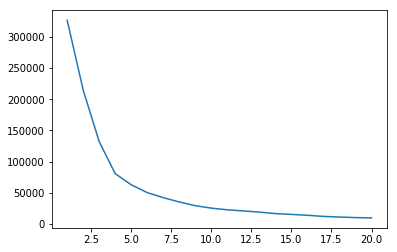

In [12]:
k_inertia = []
ks = range(1,21)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(geo_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

plt.plot(ks, k_inertia)

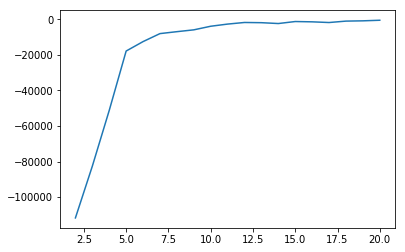

In [13]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

In [14]:
diff_r = diff[1:] / diff[:-1]
k_opt = ks[np.argmin(diff_r)+1]
k_opt

4

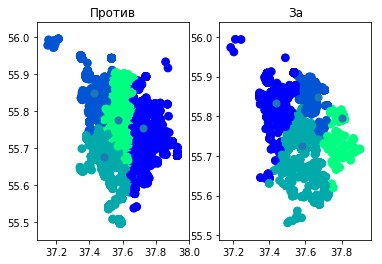

In [15]:
geo_grouped = geo.groupby(['comment_class'])

fig, axes = plt.subplots(1, geo_grouped.ngroups)

for ax, (key, group) in zip(axes, geo_grouped):
    algorithm = KMeans(n_clusters=k_opt, n_jobs=-1)
    cluster_pred = algorithm.fit_predict(group[['x', 'y']])
    ax.scatter(group['x'], group['y'], c=cluster_pred, cmap='winter', s=60)
    ax.set_title('За' if key == 1 else 'Против')
    centers = algorithm.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], s=50)

279


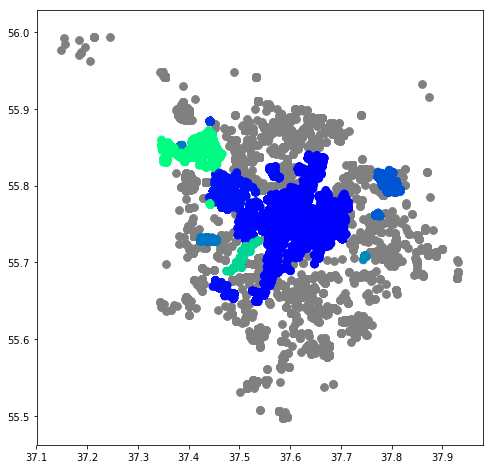

In [16]:
X = geo[['x', 'y']]
algorythm = DBSCAN(eps=0.008, min_samples=1, n_jobs=-1)
cluster_pred = algorythm.fit_predict(X)
fig, axes = plt.subplots(1, 1, figsize=(8,8))

clusters, cluster_counts = np.unique(cluster_pred, return_counts=True)
print(len(cluster_counts))
high_density_clusters = clusters[np.where(cluster_counts >= 1000)]
low_density_clusters = clusters[np.where(cluster_counts < 1000)]

colors = []

X.loc[:, 'cluster'] = cluster_pred
X.loc[:, 'high_density'] = [c in high_density_clusters for c in cluster_pred]
low = X[X['high_density'] == False]
axes.scatter(low.x, low.y, c='grey', s=60)
high = X[X['high_density'] == True]
axes.scatter(high.x, high.y, c=high.cluster, cmap='winter', s=60)